<a href="https://colab.research.google.com/github/RAKAMSTR/MBA_PROJECT/blob/master/Handwriting_Recongnition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data** **Collection**

In [1]:
# Downloading the zip file of words
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [2]:
# Lets check first 20 records
# !head -20 data/words.txt

In [49]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
# from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from keras.layers import StringLookup


np.random.seed(42)
tf.random.set_seed(42)

In [77]:
keras.version()

'3.5.0'

Dataset Splitting

In [4]:
base_path = "data"
words_list = []

# Ignore commented lines and lets copy all words to words list
words = open(f"{base_path}/words.txt","r").readlines()
for line in words:
  if line[0] == "#" :
    continue
  if line.split(" ")[1] != "err" : #avoid error entries
    words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [5]:
print(words_list[0:15])

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n', 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n', 'g06-050k-00-07 ok 156 1842 717 85 76 PP$ his\n', 'm01-100-01-06 ok 185 1459 880 177 131 JJ flying\n', 'n02-033-04-01 ok 149 940 1486 353 85 VBD presented\n', 'p03-047-00-01 ok 191 393 739 127 80 UH No\n', 'g06-011e-08-00 ok 154 386 2190 70 44 CS as\n']


In [6]:
len(words_list)

96456

In [7]:
split_idx = int(0.9 * len(words_list))
train_samples= words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(test_samples) + len(validation_samples)

print(f"Training samples are: {len(train_samples)}")
print(f"Test samples are: {len(test_samples)}")
print(f"Validation samples are: {len(validation_samples)}")


Training samples are: 86810
Test samples are: 4823
Validation samples are: 4823


In [8]:
base_image_path = os.path.join(base_path, "words")

def get_image_path_and_labels(samples):
  paths = []
  corrected_samples = []
  for(i, file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")

    # Image complete path
    # part1/part1-part2/part1-part2-part3.png
    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]

    img_path = os.path.join(
        base_image_path, partI , partI + "-" + partII, image_name + ".png"
    )
    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples

train_img_paths, train_labels = get_image_path_and_labels(train_samples)
test_img_paths, test_labels = get_image_path_and_labels(test_samples)
validation_img_paths, validation_labels = get_image_path_and_labels(validation_samples)


In [9]:
train_img_paths[0:10]

['data/words/e04/e04-030/e04-030-04-08.png',
 'data/words/k02/k02-102/k02-102-05-03.png',
 'data/words/a01/a01-082u/a01-082u-01-04.png',
 'data/words/m01/m01-000/m01-000-07-00.png',
 'data/words/g01/g01-031/g01-031-07-06.png',
 'data/words/f07/f07-081b/f07-081b-01-06.png',
 'data/words/n03/n03-082/n03-082-04-03.png',
 'data/words/g06/g06-018c/g06-018c-04-05.png',
 'data/words/g06/g06-011j/g06-011j-06-06.png',
 'data/words/f04/f04-024/f04-024-01-06.png']

In [10]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Max length ", max_len)
print("Vocabulary size ", len(characters))

train_labels_cleaned[0:10]

Max length  21
Vocabulary size  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Clean the validation and test labels

In [11]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [12]:
validation_labels_cleaned[0:10]

['able', 'full', '.', 'act', 'you', 'National', '-', 'abyss', 'said', 'in']

In [13]:

AUTOTUNE = tf.data.AUTOTUNE

# Map Characters to INT
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping int to chars again
num_to_char = StringLookup(
    vocabulary = char_to_num.get_vocabulary(), mask_token=None, invert = True
)

In [14]:
def distortion_free_resize(image, img_size):
  w,h = img_size
  image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

  # Check padding to be done
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height + 1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2


  if pad_width % 2 != 0:
      width = pad_width // 2
      pad_width_left = width + 1
      pad_width_right = width
  else:
      pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image,
      paddings=[
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0,0],
      ],
  )

  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)

  return image

In [15]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image)
  image = distortion_free_resize(image, img_size )
  image = tf.cast(image, tf.float32) / 255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
  return label

def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label" : label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
      process_images_labels, num_parallel_calls=AUTOTUNE
  )
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [16]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)


In [17]:
# train_ds

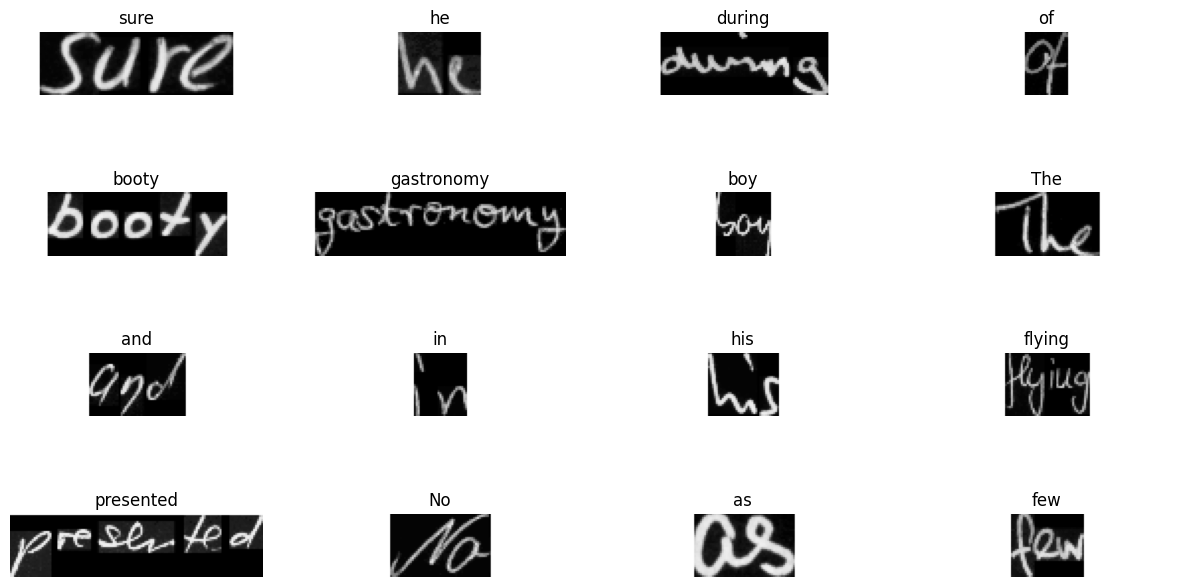

In [18]:
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]

  _, ax = plt.subplots(4, 4, figsize=(15,8))
  for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1,0,2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where label != padding_token.
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="Greys")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")


plt.show()


In [20]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [21]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = keras.ops.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.ops.nn.ctc_decode(
        predictions, sequence_lengths=input_len
    )[0][0][:, :max_len]
    sparse_predictions = keras.ops.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

********* Lets TRAIN the model here *********

In [22]:
epochs = 20  # To get good increase this number further e.g 40-50

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").output, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [50]:
MODEL_NAME = 'handwriting_recognizer_20'
MODEL_OUTPUT_PATH = '/content/PATILRAKESH/model/'

def save_model():
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    model.save(os.path.join(
        MODEL_OUTPUT_PATH, f'{MODEL_NAME}.keras'))
    # model.save(os.path.join(
    #     MODEL_OUTPUT_PATH, f'{MODEL_NAME}.h5'))
    # model.save_weights(os.path.join(
    #     MODEL_OUTPUT_PATH, f'{MODEL_NAME}.weights.h5'))
    # keras.saving.save_model(model, os.path.join(
    #     MODEL_OUTPUT_PATH, f'{MODEL_NAME}_sm.keras'))

save_model()

In [37]:
# from google.colab import drive
# drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [38]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.ops.nn.ctc_decode(pred, sequence_lengths=input_len)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = (
            tf.strings.reduce_join(num_to_char(res))
            .numpy()
            .decode("utf-8")
            .replace("[UNK]", "")
        )
        output_text.append(res)
    return output_text




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


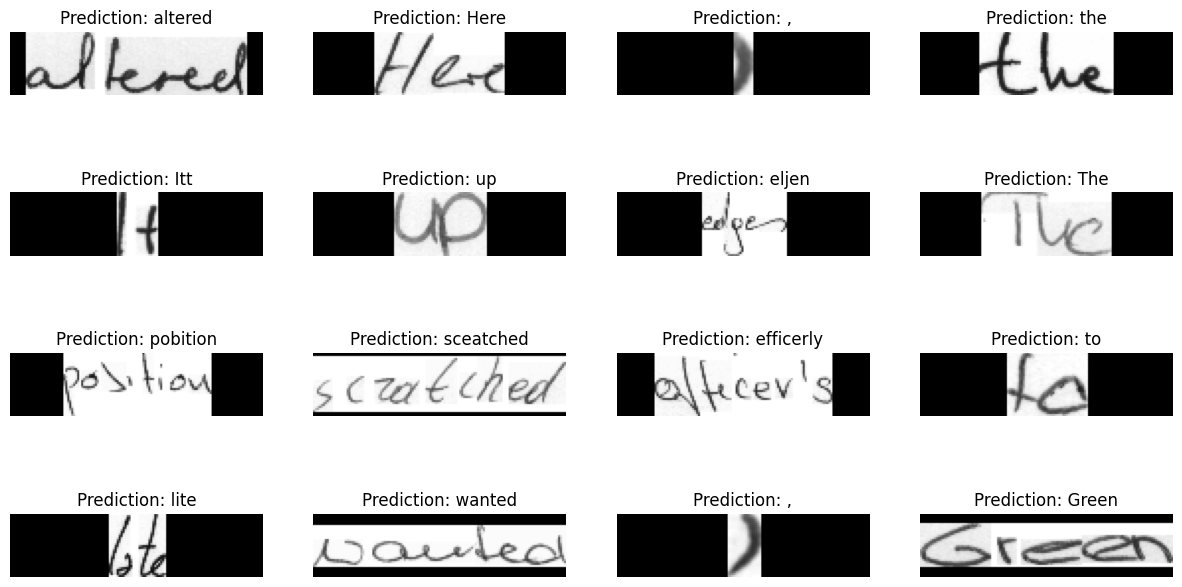

In [25]:
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = keras.ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

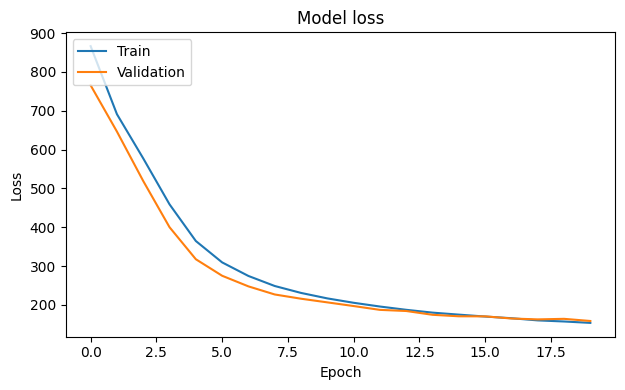

In [26]:
def visualize_train_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

visualize_train_history(history)

In [27]:
def evaluate_model():

  accuracy = model.evaluate(test_ds)
  print("Test Accuracy:", ((1000 - accuracy) / 10))


evaluate_model()

76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 158.3044
Test Accuracy: 84.17210540771484


In [45]:
print( model.get_metrics_result() )


{'loss': 158.27894592285156}


In [96]:
custom_objects = {"CTCLayer": CTCLayer}

with keras.utils.custom_object_scope(custom_objects):
    loaded_model = keras.models.load_model("/content/PATILRAKESH/model/handwriting_recognizer_20.h5", compile=True)

# loaded_model = keras.models.load_model('/content/PATILRAKESH/model/handwriting_recognizer_20.h5', custom_objects={'ctc_loss': CTCLayer})

# Show the model architecture
loaded_model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 128, 32, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 32, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 16, 32)     │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 64, 16, 64)     │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 32, 8, 64)      │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 512)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32, 64)         │         32,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 32, 256)        │        197,632 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 32, 128)        │        164,352 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 32, 81)         │         10,449 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 32, 81)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 424,083 (1.62 MB)

 Trainable params: 424,081 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


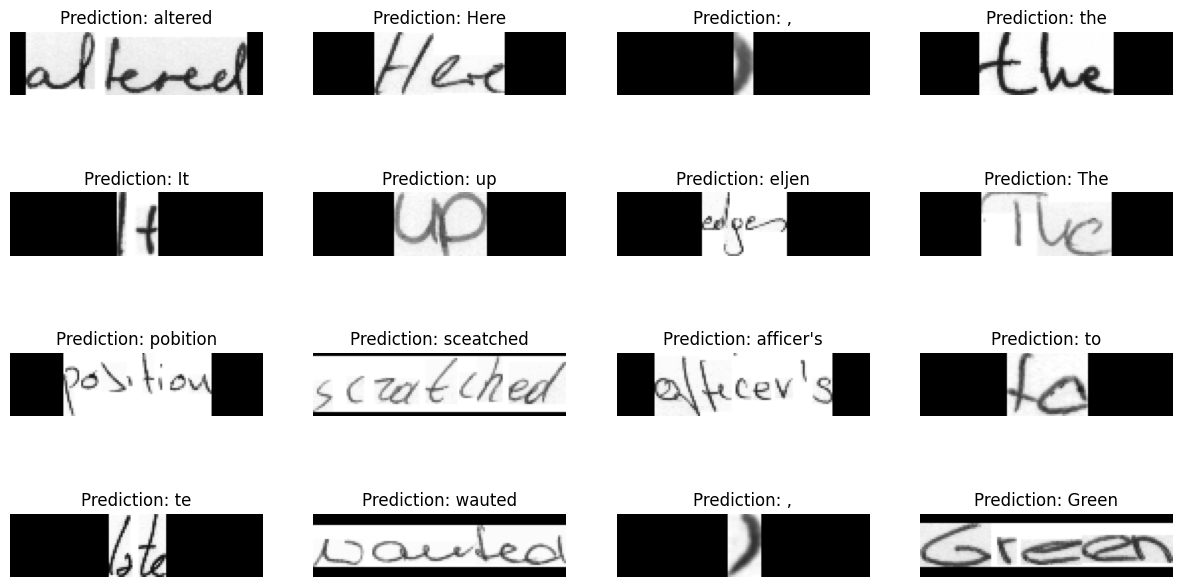

In [101]:
import numpy as np
from keras.preprocessing import image

# img_width, img_height = 128, 32
# img = image.load_img('./model/Hello.png', target_size = (img_width, img_height))
# img = image.img_to_array(img)
# img = np.expand_dims(img, axis = 0)
test2_ds = prepare_dataset(["./Hello.png"], ['Hello_test'])

prediction_model_2 = keras.models.Model(
    loaded_model.get_layer(name="image").output, loaded_model.get_layer(name="dense2").output
)

edit_distance_callback = EditDistanceCallback(prediction_model_2)
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model_2.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = keras.ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()